In [62]:
import os
import re
import json
import logging

import PIL
import cv2
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
test1 = "top_potsdam_2_10_RGB.tif"
test2 = "top_potsdam_2_10_label.tif"
exp = r"top_potsdam_([0-9]+_[0-9]+)_(RGB|label).tif"

assert re.search(exp, test1).groups() == ("2_10", "RGB")
assert re.search(exp, test2).groups() == ("2_10", "label")

In [3]:
data_path = "../data/training"
data_dict = {}

for f in os.listdir(data_path):
    if os.path.splitext(f)[-1] == ".tif":
        m = re.search(exp, f)
        if m:
            tile_id, image_type = m.groups()
            res = data_dict.get(tile_id, [None, None])
            if image_type == "label":
                res[1] = os.path.join(data_path, f)
            else:
                res[0] = os.path.join(data_path, f)
            data_dict[tile_id] = res

In [4]:
def subimage(img, center, theta, width, height):
    ''' 
    Rotates OpenCV image around center with angle theta (in deg)
    then crops the image according to width and height.

    Reference: 
    https://stackoverflow.com/questions/11627362/how-to-straighten-a-rotated-rectangle-area-of-an-image-using-opencv-in-python
    '''

    # Uncomment for theta in radians
    #theta *= 180/np.pi
    
    image = img.copy()
    shape = ( image.shape[1], image.shape[0] ) # cv2.warpAffine expects shape in (length, height)
    
    matrix = cv2.getRotationMatrix2D( center=center, angle=theta, scale=1 )
    image = cv2.warpAffine( src=image, M=matrix, dsize=shape )

    x = int( center[0] - width/2  )
    y = int( center[1] - height/2 )

    image = image[ y:y+height, x:x+width ]
    
    # my part
    px, py = np.where((image[:, :, 0] != 0) & (image[:, :, 1] != 0) & (image[:, :, 2] != 0))
    x_max, x_min = np.max(px), np.min(px)
    y_max, y_min = np.max(py), np.min(py)
    
    chunk = image[x_min:x_max, y_min:y_max, :].copy()
    del(image) # somehow there is a memory leak
    return chunk

def get_tilt(coord):
    # index 0 is the top left corner
    d = np.linalg.norm(coord[0] - coord, axis=1)
    idx_second_longest = d.argsort()[-2]
    
    # get direction vector
    vec = np.array(coord[idx_second_longest] - coord[0], dtype=float) 
    vec /= np.linalg.norm(vec)
    
    # align all the car respect to x axis
    ang = np.arccos(vec.dot([1, 0])) * 180 / np.pi
    pos = np.sign(np.cross([1, 0], vec))
    ang = pos*ang
    
    return ang

def load_images_cv(path, filter_car=False):
    """Load images using opencv which is much faster than PIL"""
    ret = cv2.imread(path)
    
    if ret is None:
        raise RuntimeError(f"{path} is not exists.")
        
    ret = cv2.cvtColor(ret, cv2.COLOR_BGR2RGB)
    if filter_car:
        r = ret[:, :, 0] == 255
        b = ret[:, :, 1] == 255
        g = ret[:, :, 2] == 0
        ret = r * b * g    
        
    return ret

def load_cars_bbox(path):
    coords = []
    
    with open(path, "r") as f:
        data = json.load(f)
        
        labels = data["labels"]
        polygons = data["polygons"]
        
        for label, polyon in zip(labels, polygons):
            if label == "car":    
                coords.append(np.array(polyon["coordinates"][0][:-1], dtype=int))
                
    return coords

def crop_car(img, coord, buffer=5):
    ang = get_tilt(coord)
    r, c, _ = img.shape

    x_min, x_max = max(0, coord[:, 0].min() - buffer), min(r, coord[:, 0].max() + buffer)
    y_min, y_max = max(0, coord[:, 1].min() - buffer), min(c, coord[:, 1].max() + buffer)

    w, h = x_max - x_min, y_max - y_min
    cx, cy = (x_max + x_min)//2, (y_min + y_max)//2
    car_aligned = subimage(img, (cx, cy), ang, max(w, h), min(h, w))
    
    car_orignal = img[y_min:y_max, x_min:x_max, :]
    
    return car_orignal, car_aligned

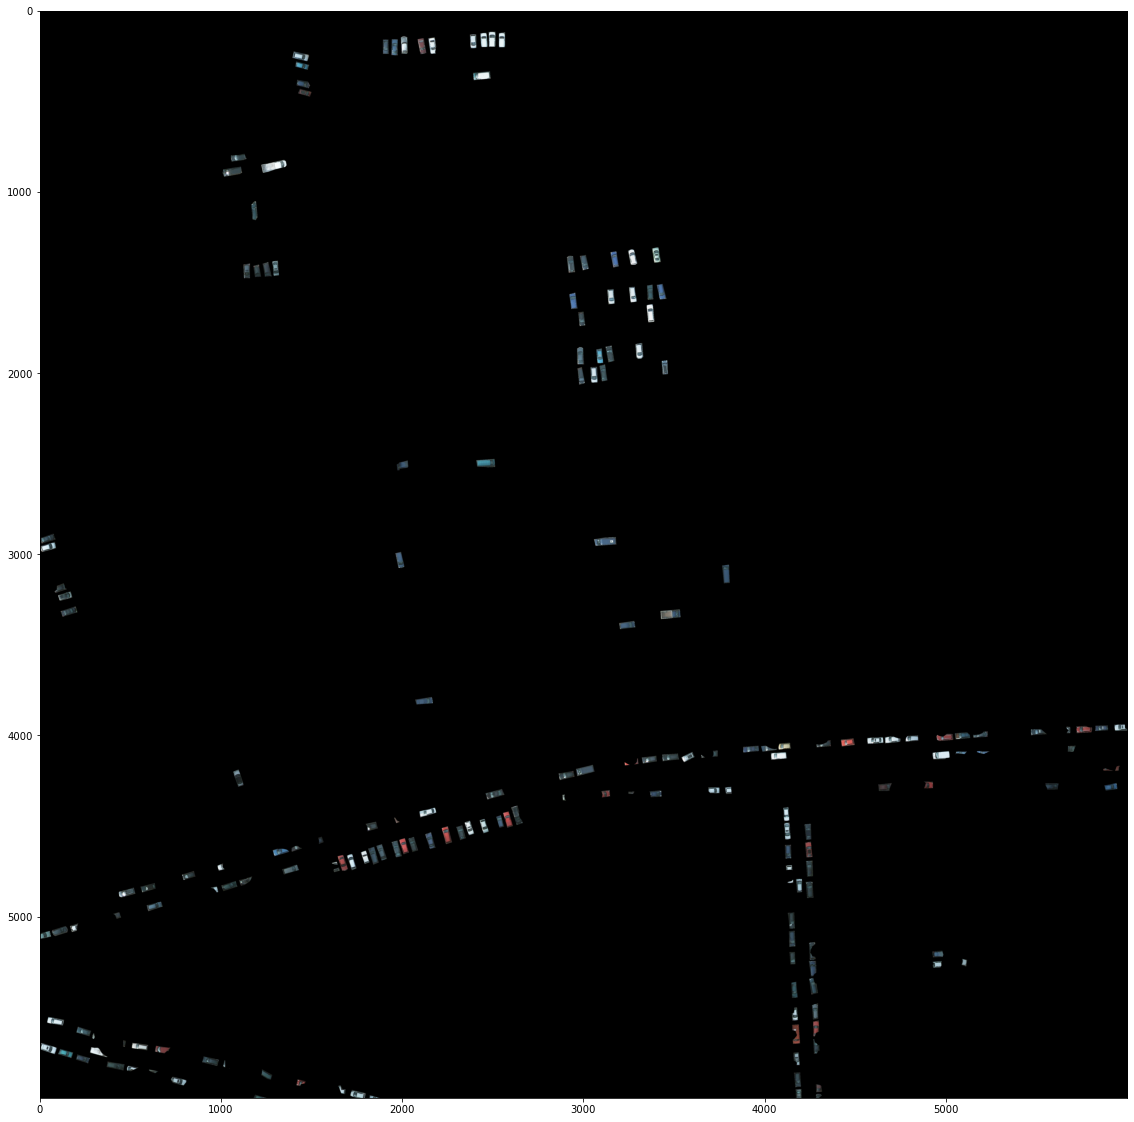

In [64]:
mask = load_images_cv('../data/training/top_potsdam_6_8_label.tif', True)
img = load_images_cv('../data/training/top_potsdam_6_8_RGB.tif', False)
img_filtered = img * mask[:, :, None]
plt.figure(figsize=(20, 20))
plt.imshow(img_filtered)

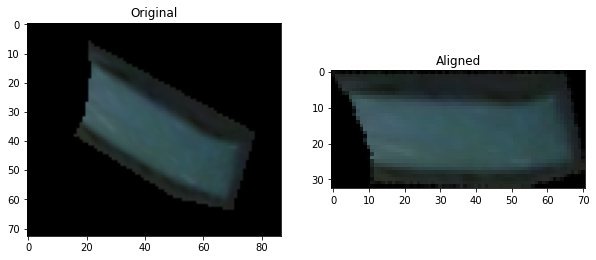

In [6]:
coords = load_cars_bbox('../data/training/top_potsdam_6_8_annos.json')
x = coords[11]
buffer = 5

car_original, car_aligned = crop_car(img_filtered, x, buffer)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(car_original)

plt.subplot(1, 2, 2)
plt.title("Aligned")
plt.imshow(car_aligned)

In [63]:
cars = []
buffer = 5
treshold = 0.9
ratio = 2
logging.basicConfig(filename='test.log', encoding='utf-8', level=logging.DEBUG)
print = logging.info

for key in data_dict:
    rgb_path, label_path = data_dict[key]
    print(f"::Reading RBG => {rgb_path}")
    print(f"::Reading Label => {label_path}")
    
    mask = load_images_cv(label_path, True)
    img = load_images_cv(rgb_path, False)
    img_filtered = img * mask[:, :, None]
    
    coords = load_cars_bbox(os.path.join(data_path, f"top_potsdam_{key}_annos.json"))
    print(f"::Total number of unique cars => {len(coords)}")
    
    # ignore ground
    for i, coord in enumerate(coords):
        try:
            car_original, car_aligned = crop_car(img_filtered, coord, buffer)
            r, c, _ = car_aligned.shape
            car_area = np.sum((car_aligned[:, :, 0] != 0) & \
                          (car_aligned[:, :, 1] != 0) & \
                          (car_aligned[:, :, 2] != 0))
            background_area = r*c
            if r == 0 or c == 0:
                raise RuntimeError(f"Image has empty rows ({r}) or cols ({c})")
            elif car_area / background_area < treshold:
                raise RuntimeError(
                    f"Mask of car is not complete, ratio of car and background is {car_area / (r*c)}")
            elif c < ratio*r:
                raise RuntimeError(
                    f"Aspect ratio of car is not correct rows ({r}) and cols ({c})")
        except Exception as e:
            print(f"::BBOX index is {i} and coordinates are,")
            print(coord)
            print(f"::Failed => {e}")
            continue
        cars.append(car_aligned)
    # assert False
        
    

ValueError: Unrecognised argument(s): encoding

In [60]:
cars2 = cars

In [49]:
len(cars)

1355

In [39]:
for i, car in enumerate(cars):
    print(i, car.shape[0], car.shape[1])

0 35 82
1 35 95
2 36 87
3 32 73
4 34 77
5 40 91
6 31 89
7 34 77
8 34 91
9 34 88
10 32 89
11 31 69
12 35 88
13 36 89
14 35 85
15 37 90
16 34 82
17 38 90
18 34 85
19 33 74
20 32 69
21 34 89
22 37 88
23 35 76
24 35 86
25 34 79
26 36 90
27 37 94
28 35 77
29 36 87
30 32 77
31 34 94
32 31 78
33 38 103
34 37 100
35 35 70
36 38 85
37 36 92
38 41 99
39 35 81
40 37 91
41 39 89
42 44 94
43 32 88
44 35 89
45 32 74
46 35 83
47 31 72
48 37 87
49 45 109
50 36 89
51 40 101
52 36 88
53 44 122
54 45 102
55 38 86
56 33 92
57 34 78
58 33 82
59 38 97
60 36 88
61 40 86
62 32 78
63 36 99
64 36 90
65 37 83
66 35 85
67 33 83
68 37 86
69 34 68
70 36 80
71 32 82
72 36 94
73 36 82
74 35 86
75 38 88
76 39 83
77 43 106
78 47 139
79 42 95
80 39 89
81 32 78
82 34 88
83 36 86
84 38 91
85 37 99
86 35 78
87 33 83


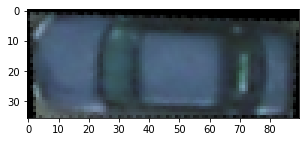

In [74]:
plt.figure(figsize=(5, 2))
plt.imshow(cars2[26])

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(img_filtered)